In [1]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
#@save
class PositionWiseFFN(nn.Module):
    """position-wise feed-forward network."""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
        
    def forward(self, X):
        # shape of X: (batch_size, seq_len, ffn_num_input)
        # shape of output: (batch_size, seq_len, ffn_num_outputs)
        return self.dense2(self.relu(self.dense1(X)))

In [3]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0] # shape of output: (3, 8) means (seq_len, ffn_num_outputs)

tensor([[-0.5589,  0.4165, -0.0882,  0.3109, -0.5807, -0.1389, -0.3171, -0.1202],
        [-0.5589,  0.4165, -0.0882,  0.3109, -0.5807, -0.1389, -0.3171, -0.1202],
        [-0.5589,  0.4165, -0.0882,  0.3109, -0.5807, -0.1389, -0.3171, -0.1202]],
       grad_fn=<SelectBackward0>)

In [4]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32) # shape of X: (2, 2)
# Compute mean and variance from X in the training mode
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [5]:
#@save
class AddNorm(nn.Module):
    """operate layer normalization after residual connection"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
        
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [6]:
add_norm = AddNorm(normalized_shape=[3, 4], dropout=0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

### Encoder

In [7]:
#@save
class EncoderBlock(nn.Module):
    """Transformer encoder block"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape,
                 ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)
    
    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [8]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(key_size=24, query_size=24, value_size=24, num_hiddens=24, norm_shape=[100, 24],
                           ffn_num_input=24, ffn_num_hiddens=48, num_heads=8, dropout=0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [9]:
#@save
class TransformerEncoder(d2l.Encoder):
    """Transformer encoder"""
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape,
                 ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens=num_hiddens, dropout=dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size=key_size, query_size=query_size, value_size=value_size, num_hiddens=num_hiddens,
                             norm_shape=norm_shape, ffn_num_input=ffn_num_input, ffn_num_hiddens=ffn_num_hiddens,
                             num_heads=num_heads, dropout=dropout, use_bias=use_bias))
    
    def forward(self, X, valid_lens, *args):
        # the positional encoding value is between -1 and 1
        # so it uses embedding value multiplied by sqrt(embedding_dim) to scale the value
        # then add up with the positional encoding value
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [10]:
encoder = TransformerEncoder(
    vocab_size=200, key_size=24, query_size=24, value_size=24, num_hiddens=24,
    norm_shape=[100, 24], ffn_num_input=24, ffn_num_hiddens=48, num_heads=8, num_layers=2, dropout=0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape
# in transformer encoder, the input shape is (batch_size, seq_len)
# the output shape is (batch_size, seq_len, num_hiddens)

torch.Size([2, 100, 24])

### Decoder

In [11]:
class DecoderBlock(nn.Module):
    """i-th block in the decoder"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(key_size=key_size, query_size=query_size, value_size=value_size,
                                                 num_hiddens=num_hiddens, num_heads=num_heads, dropout=dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(key_size=key_size, query_size=query_size, value_size=value_size,
                                                 num_hiddens=num_hiddens, num_heads=num_heads, dropout=dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
    
    def forward(self, X, state):
        # state[0]: enc_outputs, state[1]: enc_valid_lens, state[2]: dec_outputs
        enc_outputs, enc_valid_lens = state[0], state[1]
        # training stage, all the tokens are used at the same time
        # so the state[2][self.i] is initialized by None
        # testing stage, the tokens are used one by one
        # so the state[2][self.i] is initialized by the previous block
        if state[2][self.i] is None: # training stage (X is all the tokens)
            key_values = X
        else: # testing stage (X is one token, so we concatenate it with the previous block)
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values # update the state[2][self.i] with previous block
        if self.training: # self.training is inherited from nn.Module
            batch_size, num_steps, _ = X.shape
            # shape of dec_valid_lens: (batch_size, num_steps)
            # each line of dec_valid_lens is a [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        
        # self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # encoder-decoder attention
        # shape of enc_outputs: (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [12]:
decoder_blk = DecoderBlock(key_size=24, query_size=24, value_size=24, num_hiddens=24,
                            norm_shape=[100, 24], ffn_num_input=24, ffn_num_hiddens=48, num_heads=8, dropout=0.5, i=0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [30]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens=num_hiddens, dropout=dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size=key_size, query_size=query_size, value_size=value_size,
                             num_hiddens=num_hiddens, norm_shape=norm_shape, ffn_num_input=ffn_num_input,
                             ffn_num_hiddens=ffn_num_hiddens, num_heads=num_heads, dropout=dropout, i=i))
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # the first element of self._attention_weights is the self-attention weights
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # the second element of self._attention_weights is the encoder-decoder attention weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state
    
    @property
    def attention_weights(self):
        return self._attention_weights

### Training

loss 0.033, 12446.0 tokens/sec on cuda:0


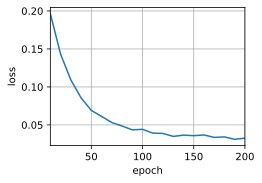

In [31]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    vocab_size=len(src_vocab), key_size=key_size, query_size=query_size, value_size=value_size,
    num_hiddens=num_hiddens, norm_shape=norm_shape, ffn_num_input=ffn_num_input,
    ffn_num_hiddens=ffn_num_hiddens, num_heads=num_heads, num_layers=num_layers,
    dropout=dropout)
decoder = TransformerDecoder(
    vocab_size=len(tgt_vocab), key_size=key_size, query_size=query_size, value_size=value_size,
    num_hiddens=num_hiddens, norm_shape=norm_shape, ffn_num_input=ffn_num_input,
    ffn_num_hiddens=ffn_num_hiddens, num_heads=num_heads, num_layers=num_layers,
    dropout=dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [37]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device, save_attention_weights=True)
    print(f'{eng} => {translation}, ', f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est malade .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


### Visualization of the attention weights

#### self-attention weights of Encoder

In [38]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

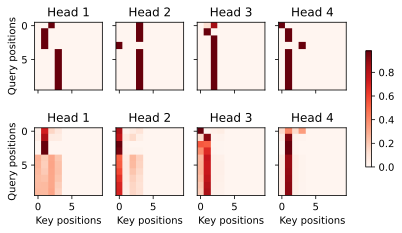

In [39]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

#### self-attention weights, encoder-decoder attention weights

In [43]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step
                            for blk in attn
                            for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
# self-attention weights, encoder-decoder attention weights
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

*self-attention weights*

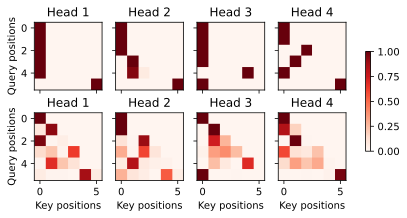

In [41]:
# plus one to include the end-of-sequence token
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3))

*encoder-decoder attention weights*

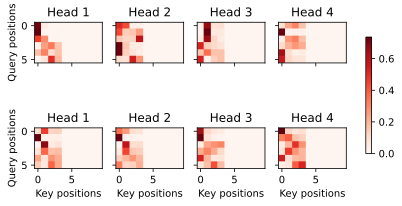

In [44]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))